In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
#importing the files
holidays = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
transactions = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')

Let's have a peek into the respective dataframes and see what the data looks like.

In [3]:
print(holidays.head(5))
print(holidays.tail(5))

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
           date        type    locale locale_name description  transferred
345  2017-12-22  Additional  National     Ecuador   Navidad-3        False
346  2017-12-23  Additional  National     Ecuador   Navidad-2        False
347  2017-12-24  Additional  National     Ecuador   Navidad-1        False
348  2017-12-25     Holiday  National     Ecuador     Navidad        False
349  2017-12-26  Additional  National     Ecuado

There are 350 rows in total. 
Columns such as "locale_name" and "description" does not contribute anything towards the forecasting and therefore, dropping the said columns would be a good idea.
"transferred" column carries boolean values. False indicates that the holiday was celebrated on that exact day while True indicates that a seperate day was assigned to celebrate that holiday. Thus, rows with True in "transferred" column might not provide valuable insight and should be dropped.

In [4]:
holidays.drop(['locale_name', 'description'], axis=1, inplace=True)
holidays.drop(holidays.index[holidays['transferred']=='True'], inplace=True)

In [5]:
holidays

,date,type,locale,transferred
0,2012-03-02,Holiday,Local,False
1,2012-04-01,Holiday,Regional,False
2,2012-04-12,Holiday,Local,False
3,2012-04-14,Holiday,Local,False
4,2012-04-21,Holiday,Local,False
...,...,...,...,...
345,2017-12-22,Additional,National,False
346,2017-12-23,Additional,National,False
347,2017-12-24,Additional,National,False
348,2017-12-25,Holiday,National,False


In [6]:
print(oil.head(5))
print(oil.tail(5))

         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
            date  dcoilwtico
1213  2017-08-25       47.65
1214  2017-08-28       46.40
1215  2017-08-29       46.46
1216  2017-08-30       45.96
1217  2017-08-31       47.26


The oil dataframe has only 3 columns with 1218 rows and all 3 columns can prove to be useful. Hence, we'll leave the dataframe as it is.

In [7]:
print(transactions.head(5))
print(transactions.tail(5))

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
    store_nbr       city       state type  cluster
49         50     Ambato  Tungurahua    A       14
50         51  Guayaquil      Guayas    A       17
51         52      Manta      Manabi    A       11
52         53      Manta      Manabi    D       13
53         54  El Carmen      Manabi    C        3


Among the 6 columns, "city" and "State" could be taken out of the equation without it possessing any threat towards the forecasting and thus should be dropped.

In [8]:
transactions.drop(['city', 'state'], axis=1, inplace=True)

Merging the three dataframes for a more comprehensive description of the sales data.

In [9]:
merge1 = pd.merge(holidays, oil, on='date', how='outer')
print(merge1)

            date     type    locale transferred  dcoilwtico
0     2012-03-02  Holiday     Local       False         NaN
1     2012-04-01  Holiday  Regional       False         NaN
2     2012-04-12  Holiday     Local       False         NaN
3     2012-04-14  Holiday     Local       False         NaN
4     2012-04-21  Holiday     Local       False         NaN
...          ...      ...       ...         ...         ...
1379  2017-08-25      NaN       NaN         NaN       47.65
1380  2017-08-28      NaN       NaN         NaN       46.40
1381  2017-08-29      NaN       NaN         NaN       46.46
1382  2017-08-30      NaN       NaN         NaN       45.96
1383  2017-08-31      NaN       NaN         NaN       47.26

[1384 rows x 5 columns]


Let's now create a index with DateTime and use that as reference for future analysis.

In [10]:
datetime_series = pd.to_datetime(merge1['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)

holidays_oil = merge1.set_index(datetime_index)
holidays_oil.drop('date',axis=1,inplace=True)

print(holidays_oil)

               type    locale transferred  dcoilwtico
2012-03-02  Holiday     Local       False         NaN
2012-04-01  Holiday  Regional       False         NaN
2012-04-12  Holiday     Local       False         NaN
2012-04-14  Holiday     Local       False         NaN
2012-04-21  Holiday     Local       False         NaN
...             ...       ...         ...         ...
2017-08-25      NaN       NaN         NaN       47.65
2017-08-28      NaN       NaN         NaN       46.40
2017-08-29      NaN       NaN         NaN       46.46
2017-08-30      NaN       NaN         NaN       45.96
2017-08-31      NaN       NaN         NaN       47.26

[1384 rows x 4 columns]


Now it's time to deal with the NaN values in the "dcoilwtico" column.

In [11]:
holidays_oil['dcoilwtico'].isnull().sum()

194

In [12]:
holidays_oil['dcoilwtico'] = holidays_oil['dcoilwtico'].replace(np.NaN, holidays_oil['dcoilwtico'].mean())
holidays_oil['dcoilwtico'].isnull().sum()
print(holidays_oil)

               type    locale transferred  dcoilwtico
2012-03-02  Holiday     Local       False   67.806403
2012-04-01  Holiday  Regional       False   67.806403
2012-04-12  Holiday     Local       False   67.806403
2012-04-14  Holiday     Local       False   67.806403
2012-04-21  Holiday     Local       False   67.806403
...             ...       ...         ...         ...
2017-08-25      NaN       NaN         NaN   47.650000
2017-08-28      NaN       NaN         NaN   46.400000
2017-08-29      NaN       NaN         NaN   46.460000
2017-08-30      NaN       NaN         NaN   45.960000
2017-08-31      NaN       NaN         NaN   47.260000

[1384 rows x 4 columns]


Now let's take a look at the fluctuations in oil prices along a period of time.

<AxesSubplot:>

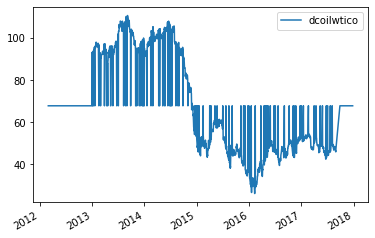

In [13]:
holidays_oil.plot(y='dcoilwtico')